In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\Kayra\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim.downloader
from gensim.models import Word2Vec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
import re
import ast


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kayra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kayra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kayra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kayra\AppData\Roaming\nltk_data...


In [4]:
import json

data_path = "dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
count = 0
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # Find the script tag with id="__NEXT_DATA__" and type="application/json"
        script_tag = soup.find('script', id='__NEXT_DATA__', type='application/json')

        #print(str(script_tag.string))
        data = json.loads(str(script_tag.string))

        # print("\n", data['props']['pageProps']["sharedConversationId"], "\n")

        try:
            mapping = data['props']['pageProps']['serverResponse']['data']['mapping']
            # Rest of the code that uses 'mapping'
        except KeyError as e:
            print(f"Error: {e}. Skipping this iteration.")
            continue

        messages = []
        for key , value in mapping.items():
          message = value.get("message")
          if message != None:
            role = message.get("author").get("role")
            if role == "user" or role == "assistant" and message != None:
              messages.append(message)

        convo_texts = []
        for message in messages:
            #print(message.items())
            role = message.get("author").get("role")
            create_time = message.get("create_time")
            content = message.get("content").get("parts")
            if content != None:
              content = '\n'.join(content)

              if role == "assistant":
                pattern = "```python(.*?)```"
                python_code = re.findall(pattern, content, re.DOTALL)

                convo_texts.append({
                    "role": role,
                    "text" : content,
                    "create_time": create_time,
                    "python_code" : "\n".join(python_code)
                })

              else:
                convo_texts.append({
                    "role": role,
                    "text" : content,
                    "create_time": create_time
                })

        code2convos[file_code] = convo_texts
    # count += 1
    # if count == 2:
    #   break

 12%|█▏        | 15/127 [00:02<00:14,  7.49it/s]

Error: 'serverResponse'. Skipping this iteration.


 45%|████▍     | 57/127 [00:08<00:08,  8.59it/s]

Error: 'serverResponse'. Skipping this iteration.


 74%|███████▍  | 94/127 [00:14<00:05,  6.23it/s]

Error: 'serverResponse'. Skipping this iteration.


 88%|████████▊ | 112/127 [00:16<00:01,  8.78it/s]

Error: 'serverResponse'. Skipping this iteration.


100%|██████████| 127/127 [00:19<00:00,  6.54it/s]


In [5]:

for code, messages in code2convos.items():
  sorted_messages = sorted(messages, key=lambda x: x['create_time'])
  code2convos[code] = sorted_messages


In [6]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'create_time': 1701015129.610132,
 'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [7]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [8]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [9]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [10]:
def preprocess_text(text):
    """
    Preprocesses the input text using NLTK.

    Parameters:
    - text (str): Input text to be preprocessed.

    Returns:
    - list: Preprocessed tokens.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]

    # Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    return words


# Apply preprocessing to each string in the list
preprocessed_propmts = [preprocess_text(text) for text in prompts]
preprocessed_questions = [preprocess_text(text) for text in questions]

# Join each inner list into a single string
preprocessed_propmts = [' '.join(inner_list) for inner_list in preprocessed_propmts]
preprocessed_questions = [' '.join(inner_list) for inner_list in preprocessed_questions]

In [11]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(preprocessed_propmts + preprocessed_questions)

In [12]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,aall,aany,abciterable,abcseries,ability,abiout,able,abs,absolute,accept,...,ytrainpred,ytrainrootsplit,ytrainshape,ytrainunique,yvalues,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

In [14]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

,aall,aany,abciterable,abcseries,ability,abiout,able,abs,absolute,accept,...,ytrainpred,ytrainrootsplit,ytrainshape,ytrainunique,yvalues,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125908,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 3951)

In [16]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [17]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [18]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.104315,0.328787,0.496131,0.264660,0.433491,0.607702,0.137032,0.109833,0.127507
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.164311,0.793324,0.754010,0.814324,0.616855,0.990033,0.888006,0.702158,0.534535
2,041f950b-c013-409a-a642-cffff60b9d4b,0.078308,0.246558,0.485508,0.296456,0.653034,0.371071,0.458817,0.491271,0.249356
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.052830,0.170351,0.173995,0.283514,0.319433,0.378487,0.271388,0.217786,0.418021
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.365054,0.652358,0.778352,0.588486,0.749370,0.891874,0.732134,0.940826,0.496782
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.095432,0.162296,0.225977,0.190857,0.176990,0.441982,1.000000,0.955334,0.751294
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.052098,0.105670,0.284364,0.919445,0.802044,0.838691,0.325093,0.904980,0.643464
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.134801,0.966993,0.976661,0.918629,0.907664,0.916722,0.717242,0.845259,0.499215
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.134801,0.966993,1.000000,0.629263,0.963902,0.908616,1.000000,1.000000,0.762249


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [19]:
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)

    if sentiment['compound'] >= 0.05:
        return 1
    elif sentiment['compound'] <= -0.05:
        return -1
    else:
        return 0

analyze_sentiment_vader("Hello please")

1

In [21]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    prevText = "Null"
    prevTime = convs[0].get("create_time")
    conv_time_intervals = []
    python_code = ""

    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts
            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            # analyse sentiment
            sent = analyze_sentiment_vader(text)
            if sent == 1:
              code2features[code]["#positive_prompt"] +=1
            elif sent == -1:
              code2features[code]["#negative_prompt"] +=1

            #check promt similarity
            if prevText != "Null":
              vectorizer = CountVectorizer().fit_transform([text, prevText])
              vectors = vectorizer.toarray()
              cosine_sim = cosine_similarity(vectors)
              code2features[code]["promt_similarity"] += cosine_sim[0][1]

            code2features[code]["prompt_avg_chars"] += len(text)
            prevText = text

            #check time intervals between user prompts
            conv_time_intervals.append(c.get("create_time") - prevTime)
            prevTime = c.get("create_time")

        else:
            # ChatGPT Responses
            #print(c["python_code"])
            python_code += ('\n' + c["python_code"])

            code2features[code]["response_avg_chars"] += len(text)
            prevText = text


    function_count = len(re.findall(r'\bdef\b', python_code))  # Count 'def' as an indicator of a function
    loop_count = len(re.findall(r'\bfor\b|\bwhile\b', python_code))

    # code2features[code]["func_count"] = function_count
    # code2features[code]["loop_count"] = loop_count


    total_time = 0
    for interval in conv_time_intervals:
      total_time += interval
    code2features[code]["total_time"] = total_time
    code2features[code]["average_time"] = total_time / len(conv_time_intervals)

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["promt_similarity"] /= code2features[code]["#user_prompts"]


In [22]:
df = pd.DataFrame(code2features).T
min_value = df['promt_similarity'].min()
max_value = df['promt_similarity'].max()

# Normalize the 'promt_similarity' column using Min-Max scaling
df['promt_similarity'] = (df['promt_similarity'] - min_value) / (max_value - min_value)

#If no positive or negative sentimet prompts found, assign 0
df['#positive_prompt'].fillna(0, inplace=True)
df['#negative_prompt'].fillna(0, inplace=True)

df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,promt_similarity,#negative_prompt,total_time,average_time
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,1.000000,2.0,3740.183183,267.155942
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,0.820281,1.0,5931.260760,329.514487
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,0.369471,4.0,28729.104035,3192.122671
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,0.535539,2.0,158752.612194,7937.630610
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,0.664835,10.0,672175.313043,7815.992012


In [24]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


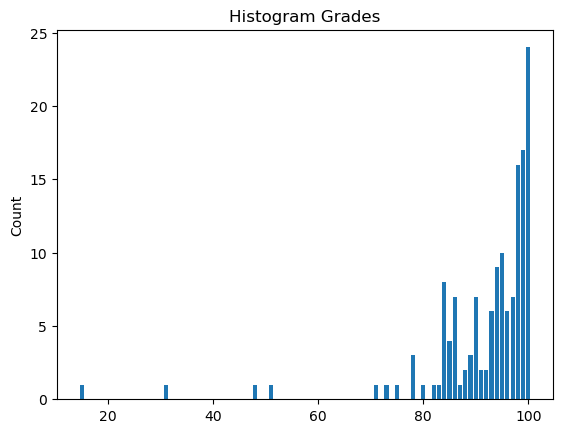

In [25]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [26]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,promt_similarity,#negative_prompt,total_time,average_time
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,1.000000,2.0,3740.183183,267.155942
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,0.820281,1.0,5931.260760,329.514487
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,0.369471,4.0,28729.104035,3192.122671
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,0.535539,2.0,158752.612194,7937.630610
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,0.664835,10.0,672175.313043,7815.992012


In [27]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,...,average_time,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,...,267.155942,0.104315,0.328787,0.496131,0.264660,0.433491,0.607702,0.137032,0.109833,0.127507
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,...,329.514487,0.164311,0.793324,0.754010,0.814324,0.616855,0.990033,0.888006,0.702158,0.534535
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,...,3192.122671,0.078308,0.246558,0.485508,0.296456,0.653034,0.371071,0.458817,0.491271,0.249356
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,...,7937.630610,0.052830,0.170351,0.173995,0.283514,0.319433,0.378487,0.271388,0.217786,0.418021
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,...,7815.992012,0.365054,0.652358,0.778352,0.588486,0.749370,0.891874,0.732134,0.940826,0.496782


#### Merging scores with features

In [35]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,...,0.104315,0.328787,0.496131,0.264660,0.433491,0.607702,0.137032,0.109833,0.127507,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,...,0.164311,0.793324,0.754010,0.814324,0.616855,0.990033,0.888006,0.702158,0.534535,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,...,0.078308,0.246558,0.485508,0.296456,0.653034,0.371071,0.458817,0.491271,0.249356,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,...,0.052830,0.170351,0.173995,0.283514,0.319433,0.378487,0.271388,0.217786,0.418021,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,...,0.365054,0.652358,0.778352,0.588486,0.749370,0.891874,0.732134,0.940826,0.496782,100.0


In [36]:
#Remove outlier datas
before_amount = temp_df.shape[0]
print("Number of data before outliers: ", before_amount)
temp_df = temp_df[temp_df['grade'] > 60]
after_amount = temp_df.shape[0]
print("Number of data after outliers are removed: ", after_amount)
print(before_amount - after_amount, "data removed")

Number of data before outliers:  122
Number of data after outliers are removed:  118
4 data removed


In [37]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(118, 22) (118,)


#### Train/Test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 94
Test set size: 24


#### Fitting a model

#### Predicting and Analyzing

In [241]:
#Linear Regression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"R^2 Score: {r2_score(y_test, y_pred)}")



Mean Squared Error (MSE): 47.10915105790042
R^2 Score: -0.33880358246253417


In [40]:
#Decision Tree Regresson. Run model with different heights to find optimal max depth

score_dict = {}

for i in range(1,21):
  regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=i)
  regressor.fit(X_train, y_train)

  # Prediction
  y_train_pred = regressor.predict(X_train)
  y_test_pred = regressor.predict(X_test)

  score_dict[i] = mean_squared_error(y_test,y_test_pred)

min_mse_depth = min(score_dict, key=score_dict.get)
print("Min MSE is observed at depth:", min_mse_depth, "with MSE:", score_dict[min_mse_depth])

Min MSE is observed at depth: 3 with MSE: 34.73894335282322


In [41]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=min_mse_depth)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [42]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 45.015504753280766
Node 1 has MSE 47.76000000000022
Node 2 has MSE 1.0
Node 3 has MSE 0.0
Node 4 has MSE 0.0
Node 5 has MSE 4.222222222222626
Node 6 has MSE 0.0
Node 7 has MSE 1.0
Node 8 has MSE 35.32306526953471
Node 9 has MSE 76.24852071005989
Node 10 has MSE 45.537190082644884
Node 11 has MSE 12.25
Node 12 has MSE 21.922437673130844
Node 13 has MSE 18.865510204082966
Node 14 has MSE 26.805555555555657


In [43]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 21.370512112001467
MSE TEST: 34.73894335282322
R2 Train: 0.5252633014085359
R2 TEST: 0.012747613418878201


In [44]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [59]:
from sklearn.model_selection import cross_val_score

# Create the base decision tree regressor
bregressor = DecisionTreeRegressor(random_state=42, criterion='squared_error')

# Create the bagging regressor
bagging_regressor = BaggingRegressor(bregressor, n_estimators=150, random_state=42, max_samples=0.5)

# Fit the bagging regressor on the entire training set
bagging_regressor.fit(X_train, y_train)

# Prediction
y_train_pred = bagging_regressor.predict(X_train)
y_test_pred = bagging_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))


print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST:", r2_score(y_test, y_test_pred))


MSE Train: 16.069521513002368
MSE TEST: 34.152368518518514
R2 Train: 0.6430225185505498
R2 TEST: 0.029417590947964034


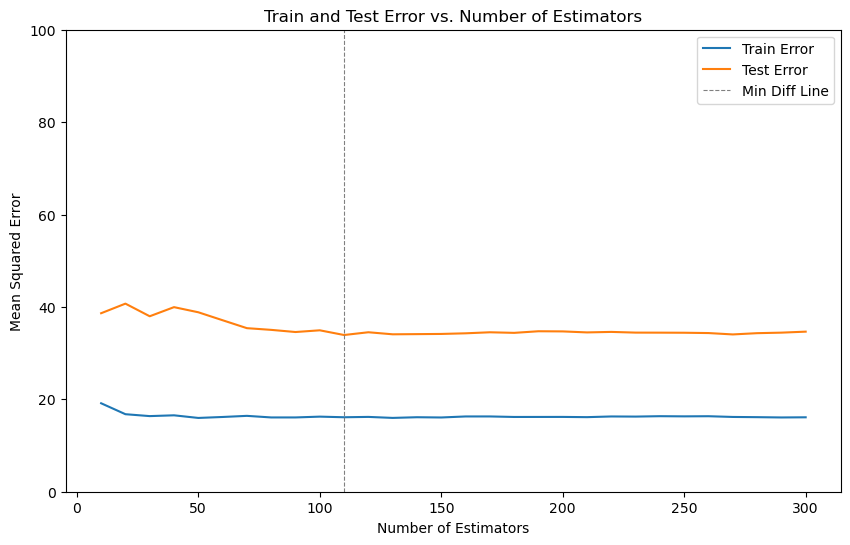

Minimum difference between test and train error at 110 estimators. Test error is 33.92034779614323
Minimum test error at 110 estimators. Test error is 33.92034779614323


BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                 max_samples=0.5, n_estimators=110, random_state=42)

In [82]:
# Create the base decision tree regressor
bregressor = DecisionTreeRegressor(random_state=42, criterion='squared_error')

# Initialize lists to store train and test errors
train_errors = []
test_errors = []

# Define a range of values for n_estimators
estimator_range = range(10, 310, 10)
# Track the minimum difference and its corresponding index
min_diff_index = None
min_diff_value = float('inf')
# Track the minimum test error and its corresponding index
min_test_index = None
min_test_value = float('inf')

# Loop through different numbers of estimators
for i, n_estimators in enumerate(estimator_range):
    # Create the bagging regressor
    bagging_regressor = BaggingRegressor(bregressor, n_estimators=n_estimators, random_state=42, max_samples=0.5)

    # Fit the bagging regressor on the training set
    bagging_regressor.fit(X_train, y_train)

    # Prediction on training and test set
    y_train_pred = bagging_regressor.predict(X_train)
    y_test_pred = bagging_regressor.predict(X_test)

    # Calculate Mean Squared Error (MSE)
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    # Update lists
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Calculate the absolute difference
    diff = abs(train_error - test_error)

    # Update minimum difference
    if diff < min_diff_value:
        min_diff_value = diff
        min_diff_index = i

    if test_error < min_test_value:
        min_test_value = test_error
        min_test_index = i

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_errors, label='Train Error')
plt.plot(estimator_range, test_errors, label='Test Error')
plt.axvline(estimator_range[min_diff_index], color='gray', linestyle='--', linewidth=0.8, label='Min Diff Line')
plt.title('Train and Test Error vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.ylim(0, 100)  # Set y-axis limits to 0-100
plt.legend()
plt.show()

print(f"Minimum difference between test and train error at {estimator_range[min_diff_index]} estimators. Test error is {test_errors[min_diff_index]}")
print(f"Minimum test error at {estimator_range[min_test_index]} estimators. Test error is {min_test_value}")

#Re-train bagging with 
best_n_estimator = estimator_range[min_diff_index]
bagging_regressor = BaggingRegressor(bregressor, n_estimators=best_n_estimator, random_state=42, max_samples=0.5)
bagging_regressor.fit(X_train, y_train)

In [83]:
# Concatenate the training and test sets for cross-validation
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Perform cross-validation
cv_scores = cross_val_score(bagging_regressor, X_combined, y_combined, cv=5, scoring='neg_mean_squared_error')

# Print cross-validation scores
print("Cross-Validation MSE Scores:", -cv_scores)  # The negation is used because cross_val_score returns negated values

# Print mean cross-validation MSE
print("Mean Cross-Validation MSE:", -np.mean(cv_scores))

Cross-Validation MSE Scores: [34.70720041 54.91342975 48.94658058 30.8772332  30.68085879]
Mean Cross-Validation MSE: 40.025060546173194


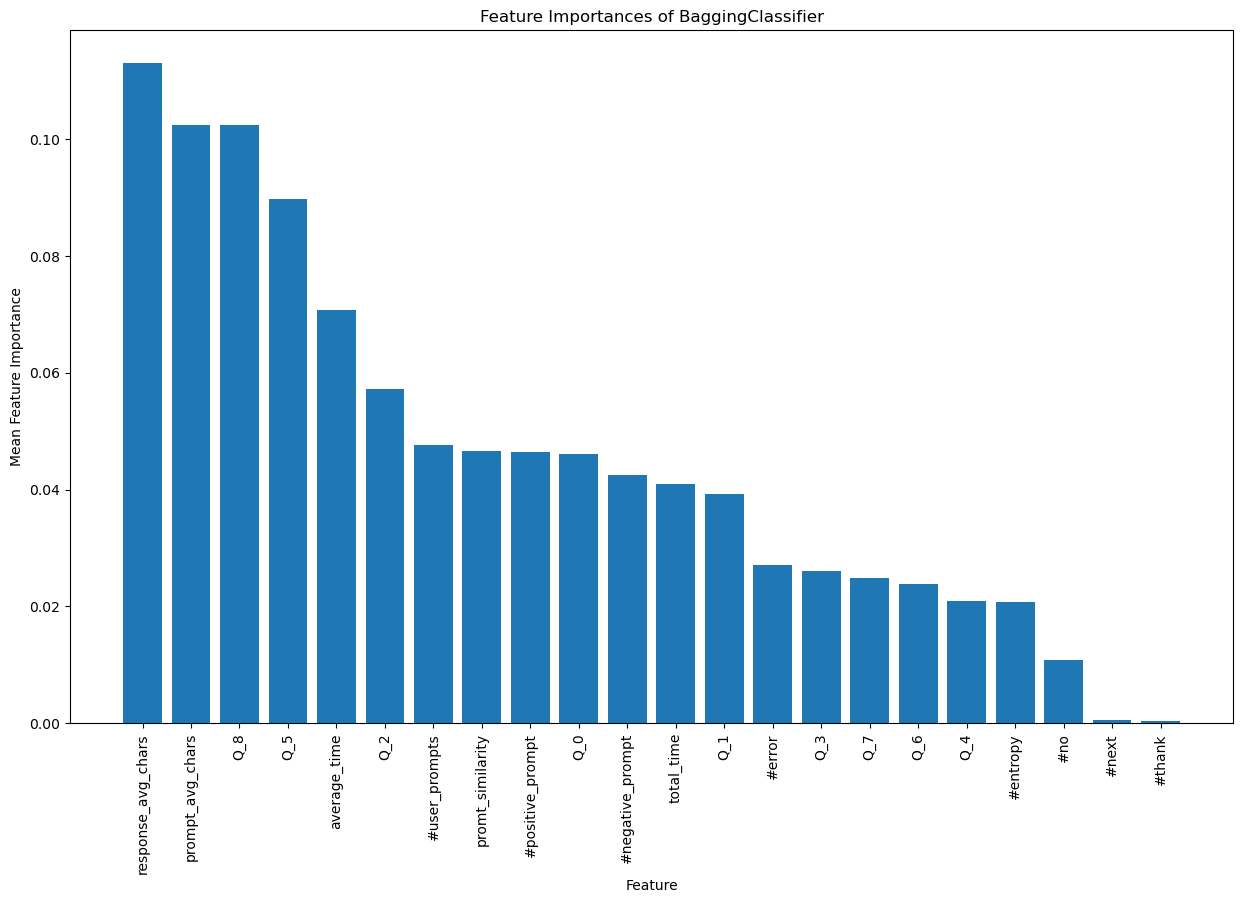

In [84]:
# Access feature importances from the individual decision trees
all_importances = np.zeros((len(bagging_regressor.estimators_), X.shape[1]))

for i, treex in enumerate(bagging_regressor.estimators_):
    all_importances[i, :] = treex.feature_importances_

# Average feature importances across all trees
average_importances = np.mean(all_importances, axis=0)

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': temp_df[temp_df.columns[1:-1]].columns, 'Importance': average_importances})

# Sort the DataFrame by importance values
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(15, 9))
plt.bar(range(X.shape[1]), importance_df['Importance'], align="center")
plt.xticks(range(X.shape[1]), importance_df['Feature'], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Mean Feature Importance")
plt.title("Feature Importances of BaggingClassifier")
plt.show()

In [86]:
#Individual errors for test data
sum = 0
for i in range(len(y_test)):
  if i != 19:
    sum += (y_test[i] - y_test_pred[i])*(y_test[i] - y_test_pred[i])
    print("i: ", i, "score: ", y_test[i] - y_test_pred[i])

print(sum/(len(y_test)-1))

i:  0 score:  9.040000000000006
i:  1 score:  3.683333333333337
i:  2 score:  2.8433333333333337
i:  3 score:  -2.9466666666666725
i:  4 score:  4.1200000000000045
i:  5 score:  8.463333333333338
i:  6 score:  -7.430000000000007
i:  7 score:  1.403333333333336
i:  8 score:  -0.6366666666666703
i:  9 score:  3.893333333333331
i:  10 score:  4.853333333333339
i:  11 score:  6.689999999999998
i:  12 score:  4.856666666666669
i:  13 score:  -0.2633333333333354
i:  14 score:  -3.0933333333333337
i:  15 score:  -8.966666666666669
i:  16 score:  4.4466666666666725
i:  17 score:  5.316666666666663
i:  18 score:  3.6700000000000017
i:  20 score:  -8.510000000000005
i:  21 score:  8.716666666666669
i:  22 score:  -7.646666666666661
i:  23 score:  0.8866666666666703
31.500002415458955
